In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [34]:
df = pd.read_csv('all_data.csv')
df[df['race_id'] == 202002020410]

,race_id,date,quarter,year,month,month_cos,month_sin,place,track,length,...,length_top3,direction_count,direction_win_score,direction_top3,win_score,jockey_id,jockey_weight,jockey_age,jockey_win_rate,jockey_win_count
0,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,1.000,1015,50,42,0.18500,2
1,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1,1,0.500000,1,0.500,1091,47,34,0.16920,0
2,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,0.333,5203,50,46,0.29270,0
3,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,0.250,1032,45,40,0.22890,0
4,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1,2,0.666500,2,0.200,1127,47,29,0.21030,1
5,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,5,11,0.321182,5,0.167,1116,47,31,0.22120,3
6,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,0.143,1163,44,23,0.19700,0
7,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,1,0.250000,0,0.125,1095,45,36,0.25980,0
8,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,1,0.125000,0,0.111,1176,46,19,0.04544,0
9,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,2,0.333500,1,0.100,5339,53,41,0.46850,2


In [35]:
# attributions * race info
len_items = sorted(df['length'].unique().tolist())
age_items = sorted(df['age'].unique().tolist())

def conv_attr(val):
    return val * 2 - 1

def conv_course(track, attr):
    return (track-1) * conv_attr(attr)

def conv_length(len, attr):
    return np.cos(np.pi * len / len_items[-1]) * conv_attr(attr)

def conv_growth(age, attr):
    return np.cos(np.pi * age / age_items[-1] * conv_attr(attr))

def conv_condition(cond, attr):
    if cond == 0:
        return -1
    if cond == 1:
        return conv_attr(attr) / 2
    return conv_attr(attr)

df['attr_course*race'] = pd.Series(np.vectorize(conv_course)(df['track'], df['attr_course']), index=df.index)
df['attr_length*race'] = pd.Series(np.vectorize(conv_length)(df['length'], df['attr_length']), index=df.index)
df['attr_leg*race'] = pd.Series(np.vectorize(conv_attr)(df['attr_leg']), index=df.index)
df['attr_growth*race'] = pd.Series(np.vectorize(conv_growth)(df['age'], df['attr_growth']), index=df.index)
df['attr_condition*race'] = pd.Series(np.vectorize(conv_condition)(df['condition'], df['attr_condition']), index=df.index)

df['weight_par_horse'] = df['jockey_weight'] / df['weight']
df['weight_par_horse'] = df['weight_par_horse'].replace(float('inf'), 0)

In [36]:
def conv_res_rate(target, other_1, other_2, other_3):
    if (target + other_1 + other_2 + other_3) == 0:
        return 0.0
    return target / (target + other_1 + other_2 + other_3)

df['f_res_1st'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_1st'], df['f_res_2nd'], df['f_res_3rd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_2nd'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_2nd'], df['f_res_1st'], df['f_res_3rd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_3rd'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_3rd'], df['f_res_1st'], df['f_res_2nd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_lose'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_lose'], df['f_res_1st'], df['f_res_2nd'], df['f_res_3rd']), index=df.index).astype(np.float32)
df['mf_res_1st'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_3rd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_2nd'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_2nd'], df['mf_res_1st'], df['mf_res_3rd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_3rd'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_3rd'], df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_lose'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_lose'], df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_3rd']), index=df.index).astype(np.float32)

In [37]:
df[df['race_id'] == 202002020410]

,race_id,date,quarter,year,month,month_cos,month_sin,place,track,length,...,jockey_id,jockey_weight,jockey_age,jockey_win_rate,jockey_win_count,attr_course*race,attr_length*race,attr_leg*race,attr_growth*race,attr_condition*race
0,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1015,50,42,0.18500,2,-0.0000,0.631706,1.0000,1.000000,-1
1,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1091,47,34,0.16920,0,-1.0000,0.631706,0.0000,0.280549,-1
2,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,5203,50,46,0.29270,0,-0.0000,-0.000000,0.0000,1.000000,-1
3,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1032,45,40,0.22890,0,-0.0000,-0.000000,0.0000,1.000000,-1
4,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1127,47,29,0.21030,1,-0.0000,-0.000000,0.0000,1.000000,-1
5,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1116,47,31,0.22120,3,-0.0000,-0.000000,0.0000,1.000000,-1
6,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1163,44,23,0.19700,0,-0.0000,-0.000000,0.0000,1.000000,-1
7,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1095,45,36,0.25980,0,-0.0000,-0.000000,0.0000,1.000000,-1
8,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1176,46,19,0.04544,0,-0.0000,-0.000000,0.0000,1.000000,-1
9,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,5339,53,41,0.46850,2,-1.0000,0.465378,-0.6380,0.863765,-1


In [38]:
cols = ['length', 'direction',
        #'weather', 'condition', 'horse_num',
        'horse_num_2', 'jockey_id', #'popularity',
        'sex', 'age', 'trainer', 'prize_center', 'prize_region',
        'attr_course*race', 'attr_length*race', 'attr_leg*race', 'attr_growth*race', 'attr_condition*race', 
        'f_res_1st', 'f_res_2nd', 'f_res_3rd', 'f_res_lose',
        'mf_res_1st', 'mf_res_2nd', 'mf_res_3rd', 'mf_res_lose', 'weight', 'jockey_weight', 'jockey_age', 'total_count', 'total_score', 'total_top3',
        'place_count', 'place_win_score', 'place_top3', 'length_count', 'length_win_score', 'length_top3', 'direction_count', 'direction_win_score',
        'direction_top3',
        # 'quarter', 'year', 'month', 
        'month_cos', 'month_sin', 'weather*condition', 'jockey_win_rate', 'jockey_win_count', 'weight_par_horse']

### CNN

In [39]:
#モデル宣言
model_cnn = Sequential()
model_cnn.add(Dense(160,activation='sigmoid', input_dim=len(cols)))#入力層+隠れ層?
model_cnn.add(Dropout(0.3))                                #過学習防止のための奴
model_cnn.add(Dense(10, activation='relu'))                #隠れ層
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1,activation='sigmoid'))               #出力層
#結合
model_cnn.compile(optimizer='adam', 
          loss='binary_crossentropy',
          metrics=['accuracy'])

#学習
df_train = df[df['date'] < '2019-07-01']
df_test = df[df['date'] >= '2019-07-01']
x_train = np.array(df_train[cols])
y_train = np.array(df_train['is_top3'])
x_test = np.array(df_test[cols])
y_test = np.array(df_test['is_top3'])

epoc = 10
hist = model_cnn.fit(x_train, y_train,
          epochs=epoc,
          batch_size=50)

Epoch 1/10
35806/35806 [==============================] - 4s 105us/step - loss: 0.5383 - accuracy: 0.7799
Epoch 2/10
35806/35806 [==============================] - 4s 111us/step - loss: 0.5169 - accuracy: 0.7831
Epoch 3/10
35806/35806 [==============================] - 4s 113us/step - loss: 0.5106 - accuracy: 0.7832
Epoch 4/10
35806/35806 [==============================] - 4s 112us/step - loss: 0.5081 - accuracy: 0.7832
Epoch 5/10
35806/35806 [==============================] - 4s 108us/step - loss: 0.5075 - accuracy: 0.7832
Epoch 6/10
35806/35806 [==============================] - 5s 129us/step - loss: 0.5063 - accuracy: 0.7832
Epoch 7/10
35806/35806 [==============================] - 5s 135us/step - loss: 0.5072 - accuracy: 0.7832
Epoch 8/10
35806/35806 [==============================] - 4s 106us/step - loss: 0.5080 - accuracy: 0.7832
Epoch 9/10
35806/35806 [==============================] - 3s 96us/step - loss: 0.5067 - accuracy: 0.7832
Epoch 10/10
35806/35806 [======================

In [40]:
score = model_cnn.evaluate(x_test, y_test, batch_size=50)
print('Test Data loss:', score[0])
print('Test Data accuracy:', score[1])

y_pred_cnn = model_cnn.predict_classes(x_test).reshape(1, len(df_test))
df_pred_cnn = pd.DataFrame({'race_id':df_test['race_id'],
                            'target':df_test['is_top3'],
                            'target_pred':y_pred_cnn[0]})

df_pred_cnn['is_correct'] = pd.Series(np.vectorize(lambda x, y: 1 if x==y else 0)(df_pred_cnn['target'], df_pred_cnn['target_pred']), index=df_pred_cnn.index)

display(df_pred_cnn[df_pred_cnn['race_id'] == 202002020410])

8370/8370 [==============================] - 0s 34us/step
Test Data loss: 0.5045910564873238
Test Data accuracy: 0.784109890460968


,race_id,target,target_pred,is_correct
0,202002020410,1,0,0
1,202002020410,1,0,0
2,202002020410,1,0,0
3,202002020410,0,0,1
4,202002020410,0,0,1
5,202002020410,0,0,1
6,202002020410,0,0,1
7,202002020410,0,0,1
8,202002020410,0,0,1
9,202002020410,0,0,1


### LightGBM

In [41]:
df_train = df[df['date'] < '2019-07-01']
df_test = df[df['date'] >= '2019-07-01']

sm = SMOTE(random_state=42)
X, Y = sm.fit_sample(df_train[cols], df_train['is_top3'])


# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X, Y)
lgb_eval = lgb.Dataset(df_test[cols], df_test['is_top3'], reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 2クラス分類
        'metric': {'binary_error'}, # 評価指標 : 誤り率(= 1-正答率)
        'learning_rate' : 0.25, #1e-5, 1e-3, 1e-2, 1e-1
        'n_estimators' : 20, #10, 50, 100, 250
        'max_depth' : 4, #3, 4, 5, 6, 10
}

# モデルの学習
model_lgbm = lgb.train(params,
                train_set=lgb_train, # トレーニングデータの指定
                valid_sets=lgb_eval, # 検証データの指定
                early_stopping_rounds=5,
                verbose_eval=50,
)

C:\Users\ayane hara\anaconda3\envs\new\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_error: 0.214337


In [42]:
# テストデータの予測 (クラス1の予測確率(クラス1である確率)を返す)
y_pred_prob_lgbm = model_lgbm.predict(df_test[cols])
# テストデータの予測 (予測クラス(0 or 1)を返す)
y_pred_lgbm = np.where(y_pred_prob_lgbm < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

# モデル評価
# acc : 正答率
acc = metrics.accuracy_score(df_test['is_top3'],y_pred_lgbm)
# logloss 
logloss = metrics.log_loss(df_test['is_top3'],y_pred_prob_lgbm) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
# AUC 
auc = metrics.roc_auc_score(df_test['is_top3'],y_pred_prob_lgbm) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)

# 真値と予測値の表示
df_pred_lgbm = pd.DataFrame({'race_id':df_test['race_id'],
                             'target':df_test['is_top3'],
                             'target_pred':y_pred_lgbm,
                             'target0_prob':1-y_pred_prob_lgbm,
                             'target1_prob':y_pred_prob_lgbm})

print(f'Acc = {acc}, logloss = {logloss}, AUC = {auc}')
display(df_pred_lgbm[df_pred_lgbm['race_id'] == 202002020410])

Acc = 0.785663082437276, logloss = 0.4762170782226789, AUC = 0.7183463229533581


,race_id,target,target_pred,target0_prob,target1_prob
0,202002020410,1,0,0.846275,0.153725
1,202002020410,1,0,0.681614,0.318386
2,202002020410,1,0,0.719973,0.280027
3,202002020410,0,0,0.772028,0.227972
4,202002020410,0,0,0.731788,0.268212
5,202002020410,0,0,0.862594,0.137406
6,202002020410,0,0,0.740014,0.259986
7,202002020410,0,0,0.775194,0.224806
8,202002020410,0,0,0.864694,0.135306
9,202002020410,0,0,0.743377,0.256623


In [43]:
def get_pred(race, prob):
    probs = df_pred_lgbm[df_pred_lgbm['race_id'] == race]['target1_prob'].values.tolist()
    probs.sort(reverse=True)
    if probs.index(prob) < 3:
        return 1
    return 0
df_pred_lgbm['target_pred_2'] = pd.Series(np.vectorize(get_pred)(df_pred_lgbm['race_id'], df_pred_lgbm['target1_prob']), index=df_pred_lgbm.index)

acc = metrics.accuracy_score(df_pred_lgbm['target'], df_pred_lgbm['target_pred_2'])
print('Acc =', acc)

display(df_pred_lgbm[df_pred_lgbm['race_id'] == 202002020410])

Acc = 0.7816009557945042


,race_id,target,target_pred,target0_prob,target1_prob,target_pred_2
0,202002020410,1,0,0.846275,0.153725,0
1,202002020410,1,0,0.681614,0.318386,1
2,202002020410,1,0,0.719973,0.280027,1
3,202002020410,0,0,0.772028,0.227972,0
4,202002020410,0,0,0.731788,0.268212,1
5,202002020410,0,0,0.862594,0.137406,0
6,202002020410,0,0,0.740014,0.259986,0
7,202002020410,0,0,0.775194,0.224806,0
8,202002020410,0,0,0.864694,0.135306,0
9,202002020410,0,0,0.743377,0.256623,0


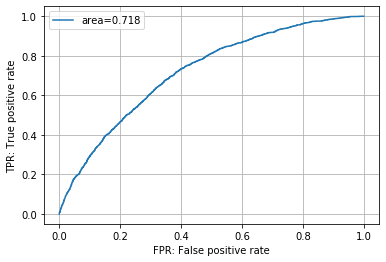

In [44]:
y_pred_prob_lgbm = model_lgbm.predict(df_test[cols])

fpr, tpr, thresholds = metrics.roc_curve(df_test['is_top3'], y_pred_prob_lgbm)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'area={round(auc, 3)}')

plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

,feature,importance
7,prize_center,0.230769
38,month_sin,0.133779
37,month_cos,0.133779
5,age,0.090301
40,jockey_win_rate,0.056856
25,total_count,0.046823
29,place_win_score,0.026756
12,attr_growth*race,0.023411
15,f_res_2nd,0.016722
27,total_top3,0.016722


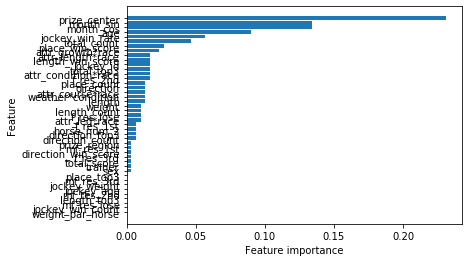

In [45]:
def plot_feature_importance(df): 
    n_features = len(df) # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
    plt.barh(range(n_features), f_imoprtance_plot, align='center') 
    cols_plot = df_plot['feature'].values # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
    plt.xlabel('Feature importance') # x軸のタイトル
    plt.ylabel('Feature') # y軸のタイトル

f_importance = np.array(model_lgbm.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

plot_feature_importance(df_importance)